# Laboratory for Systems Medicine Challenge
by Tianxing Ma (Lisa)

[Data Preparation](#Data-Preparation)
* [Categorizing ICD Codes](#Categorizing-ICD-Codes)
* [Calculating Comordity Scores](#Calculating-Comordity-Scores)
* [Obtaining Patient Information from Notes](Obtaining-Patient-Information-from-Notes)

[Tableau Visualization](#Tableau-Visualization)
* [Part I: Demographics](#Part-I:-Demographics)
* [Part II: Length of Stay](#Part-II:-Length-of-Stay)

[Creating Other Datasets](#Creating-Other-Datasets)

[Other Data Exploration](#Other-Data-Exploration)


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import math
import itertools
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import csv

## Data Preparation

In [2]:
## demographics dataset
dem=pd.read_csv("data/dem.csv")
dem.head()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,NaN,NaN
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,NaN,NaN
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,NaN,NaN
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,NaN,NaN
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,NaN,NaN


In [3]:
## diagnosis dataset
dia=pd.read_csv("data/dia.csv")
dia.head()

,empi,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient
0,412857024,2012-04-01,291.2,Alcohol-induced persisting dementia,"Hosseini, Ahmad, M.D.",admitting,inpatient
1,733570627,2011-12-07,260,Kwashiorkor,"Hansen, Michael, M.D.",primary,outpatient
2,838754425,2013-06-23,416,Chronic pulmonary heart disease,"Hansen, Michael, M.D.",admitting,inpatient
3,546413564,2010-12-11,729.1,"Mylagia and myositis, unspecified","Dirichlet, Amir, M.D.",admitting,inpatient
4,452148563,2008-07-29,272.4,Other and unspecified hyperlipidemia,"Armstrong, Sebastian, M.D.",NaN,outpatient


In [4]:
## creating a clean race variable
dem['race_clean'] = dem['race']
dem['race_clean'] = dem['race_clean'].str.replace("Black-BLACK", "Black")
dem['race_clean'] = dem['race_clean'].str.replace("BLACK OR AFRICAN AMERICAN", "Black")
dem['race_clean'] = dem['race_clean'].str.replace("White-WHITE", "White")
dem['race_clean'] = dem['race_clean'].str.replace("Asian-ASIAN", "Asian")
dem['race_clean'] = dem['race_clean'].str.replace("Hispanic-HISPANIC", "Hispanic")
dem['race_clean'] = dem['race_clean'].str.replace("American Indian-AMERICAN INDIAN", "American Indian")

In [5]:
## cleaning vital_status
dem["vital_status"] = dem["vital_status"].fillna("living")
dem.head()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death,race_clean
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,living,NaN,Black
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,living,NaN,White
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,living,NaN,White
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,living,NaN,Black
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,living,NaN,Black


### Categorizing ICD Codes

In [6]:
%%time

## creating a new category variable "disease" from given supplementary code
dia['disease'] = ""

for index, row in dia.iterrows():
    ICD = row["dia_code"]
    
    if (ICD[:3] == '196') | (ICD[:3] == '197') | (ICD[:3] == '198') | (ICD[:3] == '199'):
        dia.loc[index,"disease"] = "metastatic_romano"
        
    elif (ICD == '40201') | (ICD == '40211') | (ICD == '40291') \
    | (ICD[:4] == '4293') | (ICD[:3] == '425') | (ICD[:3] == '428'):
        dia.loc[index,"disease"] = "chf_romano"
        
    elif (ICD[:4] == '3310') | (ICD[:4] == '3311') | (ICD[:4] == '3312') | (ICD[:3] == '290'):
        dia.loc[index,"disease"] = "dementia_romano"
        
    elif (ICD == '40311') |  (ICD == '40391') | (ICD == '40412') | (ICD == '40492') \
    | (ICD[:3] == '585') | (ICD[:3] == '586') \
    | (ICD[:4] == 'V420') | (ICD[:4] == 'V451') |(ICD[:4] == 'V560') | (ICD[:4] == 'V568'):
        dia.loc[index,"disease"] = "renal_elixhauser"
        
    elif '260' <= ICD[:3] <= '263':
        dia.loc[index,"disease"] = 'wtloss_elixhauser'
        
    elif (ICD[:3] == '342') | (ICD[:3] == '344'):
        dia.loc[index,"disease"] = 'hemiplegia_romano'
        
    elif (ICD[:4] == '2911') | (ICD[:4] == '2912') |(ICD[:4] == '2915') | (ICD[:4] == '2918') \
    | (ICD[:4] == '2919') | ('30390' <= ICD <= '30393') | ('30500' <= ICD <= '30503') \
    | (ICD[:4] == 'V113'):
        dia.loc[index,"disease"] = 'alcohol_elixhauser'
        
    elif ('140' <= ICD[:3] <= '171') | ('174' <= ICD[:3] <= '195') \
    | (ICD[:4] == '2730') | (ICD[:4] == '2733') | (ICD[:4] == '2911') | (ICD[:5] == 'V1046')\
    | ('200' <= ICD[:3] <= '208'):
        dia.loc[index,"disease"] = 'tumor_romano'
        
    elif (ICD == '42610') | (ICD == '42611') | (ICD == '42613')\
    | ('4262' <= ICD[:4] <= '4264') | ('42650' <= ICD <= '42653') | ('4266' <= ICD[:4]  <= '4268')\
    | (ICD[:4] == '4270') | (ICD[:4] == '4272') | (ICD == '42731') | (ICD == '42760') | (ICD[:4] == '4279')\
    | (ICD[:4] == '7850') | (ICD[:4] == 'V450') | (ICD[:4] == 'V533'):
        dia.loc[index,"disease"] = 'arrhythmia_elixhauser'
        
    elif (ICD[:4] == '4150') | (ICD[:4] == '4168') | (ICD[:4] == '4169') | (ICD[:3] == '491')\
    | (ICD[:3] == '492') |  (ICD[:3] == '493') | (ICD[:3] == '494') | (ICD[:3] == '496'):
        dia.loc[index,"disease"] = 'pulmonarydz_romano'

    elif ('2860' <= ICD[:4] <= '2869') | (ICD[:4] == '2871') | ('2873' <= ICD[:4] <= '2875'):
        dia.loc[index,"disease"] = 'coagulopathy_elixhauser'

    elif ('25040' <= ICD <= '25073') | ('25090' <= ICD <= '25093'):
        dia.loc[index,"disease"] = 'compdiabetes_elixhauser'
        
    elif ('2801' <= ICD[:4] <= '2819')|(ICD[:4] == '2859'): 
        dia["disease"].iloc[index] = 'anemia_elixhauser'
        
    elif ('2760' <= ICD[:4] <= '2769'):
        dia.loc[index,"disease"] = 'electrolytes_elixhauser'
        
    elif (ICD == '07032') | (ICD == '07033') | (ICD == '07054') | (ICD[:4] == '4560') | (ICD[:4] == '4561')\
    | (ICD == '45620') | (ICD == '45621') | (ICD[:4] == '5710') | (ICD[:4] == '5712')\
    | (ICD[:4] == '5713') | ('57140' <= ICD <= '57149') | (ICD[:4] == '5715')\
    | (ICD[:4] == '5716') | (ICD[:4] == '5718') | (ICD[:4] == '5719') | (ICD[:4] == '5723') | (ICD[:4] == '5728') | (ICD[:4] == 'V427'):
        dia.loc[index,"disease"] = 'liver_elixhauser'
        
    elif ('4400' <=ICD[:4] <= '4409') | (ICD[:4] == '4412') | (ICD[:4] == '4414') | (ICD[:4] == '4417') | (ICD[:4] == '4419')\
    | ('4431' <= ICD[:4] <= '4439') | (ICD[:4] == '4471') | (ICD[:4] == '5571') | (ICD[:4] == '5579') | (ICD[:4] == 'V434'):
        dia.loc[index,"disease"] = 'pvd_elixhauser'

    elif ('29500' <= ICD <= '29899') | (ICD == '29910') | (ICD == '29911'):
        dia.loc[index,"disease"] = 'psychosis_elixhauser'
        
    elif (ICD[:3] == '416') | (ICD[:4] == '4179'):
        dia.loc[index,"disease"] = 'pulmcirc_elixhauser'
        
    elif (ICD[:3] == '042') | (ICD[:3] == '043') | (ICD[:3] == '044'):
        dia.loc[index,"disease"] = 'hivaids_romano'
        
    elif (ICD[:4] == '4011') | (ICD[:4] == '4019') | (ICD == '40210') | (ICD == '40290') | (ICD == '40410')\
    | (ICD == '40490') | (ICD == '40511' )| (ICD == '40519' )| (ICD == '40591') | (ICD == '40599'):
        dia.loc[index,"disease"] = 'hypertension_elixhauser'

CPU times: user 1.12 s, sys: 19.1 ms, total: 1.14 s
Wall time: 1.25 s


In [7]:
## seeing how many entries have been categorized
print len(dia[dia["disease"] != ""]), len(dia)

1261 5893


Not having most of the entries categorized makes certain later analyses difficult.

In [8]:
%%time
## new indicator variables for "disease" on the patient level

dem['wtloss_elixhauser'] = 0
dem['pulmcirc_elixhauser'] = 0
dem['metastatic_romano'] = 0
dem['tumor_romano'] = 0
dem['hemiplegia_romano'] = 0
dem['psychosis_elixhauser'] = 0
dem['pvd_elixhauser'] = 0
dem['electrolytes_elixhauser'] = 0
dem['coagulopathy_elixhauser'] = 0
dem['hivaids_romano'] = 0
dem['pulmonarydz_romano'] = 0
dem['chf_romano'] = 0

wt = dia[dia['disease'] == 'wtloss_elixhauser']["empi"].unique()
pul = dia[dia['disease'] == 'pulmcirc_elixhauser']["empi"].unique()
meta = dia[dia['disease'] == 'metastatic_romano']["empi"].unique()
tumor = dia[dia['disease'] == 'tumor_romano']["empi"].unique()
hemi = dia[dia['disease'] == 'hemiplegia_romano']["empi"].unique()
psych = dia[dia['disease'] == 'psychosis_elixhauser']["empi"].unique()
pvd = dia[dia['disease'] == 'pvd_elixhauser']["empi"].unique()
electro = dia[dia['disease'] == 'electrolytes_elixhauser']["empi"].unique()
coag = dia[dia['disease'] == 'coagulopathy_elixhauser']["empi"].unique()
hiv = dia[dia['disease'] == 'hivaids_romano']["empi"].unique()
pulmo = dia[dia['disease'] == 'pulmonarydz_romano']["empi"].unique()
chf = dia[dia['disease'] == 'chf_romano']["empi"].unique()

for index, row in dem.iterrows():
    if row["empi"] in wt:
        dem.loc[index,"wtloss_elixhauser"] = 1
    if row["empi"] in pul:
        dem.loc[index,"pulmcirc_elixhauser"] = 1
    if row["empi"] in meta:
        dem.loc[index,"metastatic_romano"] = 1
    if row["empi"] in tumor:
        dem.loc[index,"tumor_romano"] = 1
    if row["empi"] in hemi:
        dem.loc[index,"hemiplegia_romano"] = 1
    if row["empi"] in psych:
        dem.loc[index,"psychosis_elixhauser"] = 1
    if row["empi"] in pvd:
        dem.loc[index,"pvd_elixhauser"] = 1
    if row["empi"] in electro:
        dem.loc[index,"electrolytes_elixhauser"] = 1
    if row["empi"] in coag:
        dem.loc[index,"coagulopathy_elixhauser"] = 1
    if row["empi"] in hiv:
        dem.loc[index,"hivaids_romano"] = 1
    if row["empi"] in pulmo:
        dem.loc[index,"pulmonarydz_romano"] = 1
    if row["empi"] in chf:
        dem.loc[index,"chf_romano"] = 1

CPU times: user 422 ms, sys: 4.39 ms, total: 426 ms
Wall time: 447 ms


In [9]:
dem.head()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death,race_clean,wtloss_elixhauser,pulmcirc_elixhauser,metastatic_romano,tumor_romano,hemiplegia_romano,psychosis_elixhauser,pvd_elixhauser,electrolytes_elixhauser,coagulopathy_elixhauser,hivaids_romano,pulmonarydz_romano,chf_romano
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,living,NaN,Black,1,0,0,1,0,0,0,1,0,0,0,1
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,living,NaN,White,0,0,0,1,0,0,0,1,0,0,0,0
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,living,NaN,White,1,0,1,1,1,0,1,1,1,0,0,0
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,living,NaN,Black,0,0,0,1,0,0,0,0,0,0,0,1
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,living,NaN,Black,1,0,1,1,0,1,0,0,0,0,0,0


### Calculating Comordity Scores

In [10]:
## weight variables for each diagnosis

dia['weight'] = 0
dia['total_weight'] = 0
dia.loc[dia['disease'] == 'metastatic_romano','weight'] = 5;
dia.loc[dia['disease'] == 'chf_romano','weight'] = 2;
dia.loc[dia['disease'] == 'dementia_romano','weight'] = 2;
dia.loc[dia['disease'] == 'renal_elixhauser','weight'] = 2;
dia.loc[dia['disease'] == 'wtloss_elixhauser','weight'] = 2
dia.loc[dia['disease'] == 'hemiplegia_romano','weight'] = 1;
dia.loc[dia['disease'] == 'alcohol_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'tumor_romano','weight'] = 1;
dia.loc[dia['disease'] == 'arrhythmia_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'pulmonarydz_romano','weight'] = 1;
dia.loc[dia['disease'] == 'coagulopathy_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'compdiabetes_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'anemia_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'electrolytes_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'liver_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'pvd_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'psychosis_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'pulmcirc_elixhauser','weight'] = 1;
dia.loc[dia['disease'] == 'hivaids_romano','weight'] = -1;
dia.loc[dia['disease'] == 'hypertension_elixhauser','weight'] = -1;

In [11]:
dia.head()

,empi,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient,disease,weight,total_weight
0,412857024,2012-04-01,291.2,Alcohol-induced persisting dementia,"Hosseini, Ahmad, M.D.",admitting,inpatient,,0,0
1,733570627,2011-12-07,260,Kwashiorkor,"Hansen, Michael, M.D.",primary,outpatient,wtloss_elixhauser,2,0
2,838754425,2013-06-23,416,Chronic pulmonary heart disease,"Hansen, Michael, M.D.",admitting,inpatient,pulmcirc_elixhauser,1,0
3,546413564,2010-12-11,729.1,"Mylagia and myositis, unspecified","Dirichlet, Amir, M.D.",admitting,inpatient,,0,0
4,452148563,2008-07-29,272.4,Other and unspecified hyperlipidemia,"Armstrong, Sebastian, M.D.",NaN,outpatient,,0,0


In [12]:
## calculate the total score
grp = dia.groupby('empi')
dia["total_weight"] = grp[['weight']].transform(sum)
dia.head()
# dia.groupby('empi').sum()

,empi,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient,disease,weight,total_weight
0,412857024,2012-04-01,291.2,Alcohol-induced persisting dementia,"Hosseini, Ahmad, M.D.",admitting,inpatient,,0,8
1,733570627,2011-12-07,260,Kwashiorkor,"Hansen, Michael, M.D.",primary,outpatient,wtloss_elixhauser,2,4
2,838754425,2013-06-23,416,Chronic pulmonary heart disease,"Hansen, Michael, M.D.",admitting,inpatient,pulmcirc_elixhauser,1,3
3,546413564,2010-12-11,729.1,"Mylagia and myositis, unspecified","Dirichlet, Amir, M.D.",admitting,inpatient,,0,7
4,452148563,2008-07-29,272.4,Other and unspecified hyperlipidemia,"Armstrong, Sebastian, M.D.",NaN,outpatient,,0,3


In [13]:
## add total scores to demographics dataset (on patient level)
new_dem = dem.join(dia.groupby('empi')["weight"].sum(), on=['empi']) 
new_dem.head()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death,race_clean,wtloss_elixhauser,pulmcirc_elixhauser,metastatic_romano,tumor_romano,hemiplegia_romano,psychosis_elixhauser,pvd_elixhauser,electrolytes_elixhauser,coagulopathy_elixhauser,hivaids_romano,pulmonarydz_romano,chf_romano,weight
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,living,NaN,Black,1,0,0,1,0,0,0,1,0,0,0,1,8
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,living,NaN,White,0,0,0,1,0,0,0,1,0,0,0,0,4
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,living,NaN,White,1,0,1,1,1,0,1,1,1,0,0,0,12
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,living,NaN,Black,0,0,0,1,0,0,0,0,0,0,0,1,4
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,living,NaN,Black,1,0,1,1,0,1,0,0,0,0,0,0,11


### Obtaining Patient Information from Notes

In [14]:
## creating new variables for info extracted from visit notes

ids=[]
dia["los"] = ''
dia["bp_s"] = ''
dia["bp_d"] = ''
dia["pulse"] = ''
dia["rr"] = ''
dia["temp"] = ''

with open('data/ed_visits.txt') as input:
    i = 0
    empi = ''
    visit_date = ''
    for line in input:
        if i == 1:
            empi,visit_date,admit_date,discharge_date,length_of_stay,principal_dia_code,principal_dia_nam,additional_dia_code,\
            note_text = (item.strip() for item in line.split('$', 9))
            ids.append(empi)
            dia.loc[(dia["empi"]==int(empi)) & (dia["dia_date"]==visit_date), "los"] = int(length_of_stay)
            
        if 'PHYSICAL EXAMINATION' in line:
            bp_s, bp_d = line[line.index('Blood pressure')+15:line.index(', pulse')].split('/')
            dia.loc[(dia["empi"]==int(empi)) & (dia["dia_date"]==visit_date), "bp_s"] = float(bp_s)
            dia.loc[(dia["empi"]==int(empi)) & (dia["dia_date"]==visit_date), "bp_d"] = float(bp_d)
            dia.loc[(dia["empi"]==int(empi)) & (dia["dia_date"]==visit_date), "pulse"]\
            = float(line[line.index('pulse')+6:line.index(', respiratory')]) 
            dia.loc[(dia["empi"]==int(empi)) & (dia["dia_date"]==visit_date), "rr"]\
            = float(line[line.index('respiratory')+16:line.index(', temperature')])    
            dia.loc[(dia["empi"]==int(empi)) & (dia["dia_date"]==visit_date), "temp"]\
            = float(line[line.index('temperature')+12:line.index(', and')])   
        
        if '[report_end]' in line:
            i = 0
        else:
            i = i+1

In [15]:
## create a categorical variable for high blood pressure
dia["high_bp"] = ''

In [16]:
dia.loc[(dia["bp_s"]!='')&(dia["bp_s"]>140), "high_bp"] = 1
dia.loc[(dia["bp_s"]!='')&(dia["bp_s"]<=140), "high_bp"] = 0

In [17]:
## checking how many notes matched with the dia dataset
print len(ids), len(dia[dia["los"]!=''])

869 863


In [18]:
## checking how many patients were represented in the notes
len(dia[dia["los"]!='']['empi'].unique())

343

In [19]:
## creating dataset for only those entries found in the notes
matched = dia[dia["los"]!='']
matched = matched.sort('dia_date', ascending=False)

In [20]:
## get the latest diagnosis date for each patient from notes
g = matched.groupby('empi')
g_matched = g.first()

In [21]:
## the "weight" variable in new_dem gives us the most complete data on the comorbidity score
g_matched = g_matched.drop(['weight', 'total_weight'], 1)

In [24]:
## create dataset on the patient level with more variables (from the dia dataset and notes)
large_dem = new_dem.join(g_matched, on=['empi'])
large_dem.head()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death,race_clean,wtloss_elixhauser,pulmcirc_elixhauser,metastatic_romano,tumor_romano,hemiplegia_romano,psychosis_elixhauser,pvd_elixhauser,electrolytes_elixhauser,coagulopathy_elixhauser,hivaids_romano,pulmonarydz_romano,chf_romano,weight,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient,disease,los,bp_s,bp_d,pulse,rr,temp,high_bp
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,living,NaN,Black,1,0,0,1,0,0,0,1,0,0,0,1,8,2014-02-20,789.06,"Abdominal pain, epigastric","Hosseini, Ahmad, M.D.",primary,outpatient,,130,141,94,65,13,98.6,1
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,living,NaN,White,0,0,0,1,0,0,0,1,0,0,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,living,NaN,White,1,0,1,1,1,0,1,1,1,0,0,0,12,2013-07-08,433.11,Occlusion and stenosis of carotid artery with ...,"Jameson, Jan, M.D.",admitting,outpatient,,143,127,92,59,13,98.8,0
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,living,NaN,Black,0,0,0,1,0,0,0,0,0,0,0,1,4,2013-12-18,308.3,Other acute reactions to stress,"Goldhouse, Barry, M.D.",NaN,outpatient,,178,160,111,47,12,98.7,1
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,living,NaN,Black,1,0,1,1,0,1,0,0,0,0,0,0,11,2012-09-17,274.01,Acute gouty arthropathy,"Dirichlet, Amir, M.D.",admitting,outpatient,,227,164,111,56,14,98.6,1


In [25]:
large_dem.to_csv("matched_dem.csv")

The above dataset is used in Tableau for the visualization below.

## Tableau Visualization

In [41]:
%%html
<script type='text/javascript' src='https://public.tableau.com/javascripts/api/viz_v1.js'></script>
<div class='tableauPlaceholder' style='width: 1004px; height: 869px;'>
    <noscript><a href='#'><img alt='Playing with Data ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;La&#47;Lab_6&#47;Story1&#47;1_rss.png' style='border: none' /></a></noscript>
    <object class='tableauViz' width='1004' height='869' style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' />
    <param name='name' value='Lab_6&#47;Story1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;La&#47;Lab_6&#47;Story1&#47;1.png' />
    <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' />
    <param name='display_count' value='yes' />
    <param name='showTabs' value='y' /></object></div>

### Part I: Demographics

The demographics chart reveals that the racial/ethnic distribution of patients is similar between deceased and living populations. For instance, 74.81% of the deceased and 67.55% of the living are white, who make the majority of the patients. Absolute numbers labelled by the end of the bars show that more patients are living than deceased. The similar distributions allow for better comparisons between the deceased and living populations on other variables, such as the main diagnosis. 

### Part II: Length of Stay

Graphs on the individual level showed little pattern, so I decided to group patients by the physician they last saw to see if patterns were clearer on this higher level. 

The length of stay variable here represent the number of days during the patient's latest stay at the hospital, as recorded by the physician notes. In most cases, hospitals/physicians and patients would like to reduce length of stay at hospitals.

##### Comorbidity Score

Looking at the second graph in the Tableau Story, we observe that longer length of stay is associated with lower average patient comorbidity scores. Perhaps those who have higher comorbidity scores pass away sooner, leading to shorter lengths of stay. However, if we examine only the deceased population, we find little of the previous pattern. We can look at aggregate lengths of stay for further investigation.

##### High Blood Pressure

Looking at the third graph in the Tableau Story, we note that physicians who have more patients with high blood pressure also have longer average lengths of stay. This trend may not be accurate for the whole picture as Physician I could be an outlier. Moreover, examining only the deceased population reveals the oppoite pattern; lower proportion of patients with high blood pressure is associated with longer lengths of stay. Perhaps those physicians who are able to keep their patients' blood pressures below the high blood pressure threshold also help patients live longer, leading to patients' longer stays in the hospital (possibly for other health reasons).

Although the comorbidity scores and high blood pressure in this visualization did not help us find ways to reduce length of stay, we found interesting patterns that can inform future investigations. In addition, focusing to fill in the "disease" variable can help us to look at the data in more detail.

## Creating Other Datasets

In [27]:
## changing the index to make join easier later
indexed_dem = dem.set_index("empi")

In [28]:
new_dem.to_csv("new_dem.csv")

In [29]:
## create dataset on diagnosis level with more (patient) variables
large = dia.join(indexed_dem, on=['empi'])
# large.head()

In [30]:
large.to_csv("large_dia.csv")

I tried using the above dataset in Tableau but missing values of the variable "disease" made it difficult to analyze on the case level.

## Other Data Exploration

I made these graphs (and many others not shown) in an intial brainstorming process.

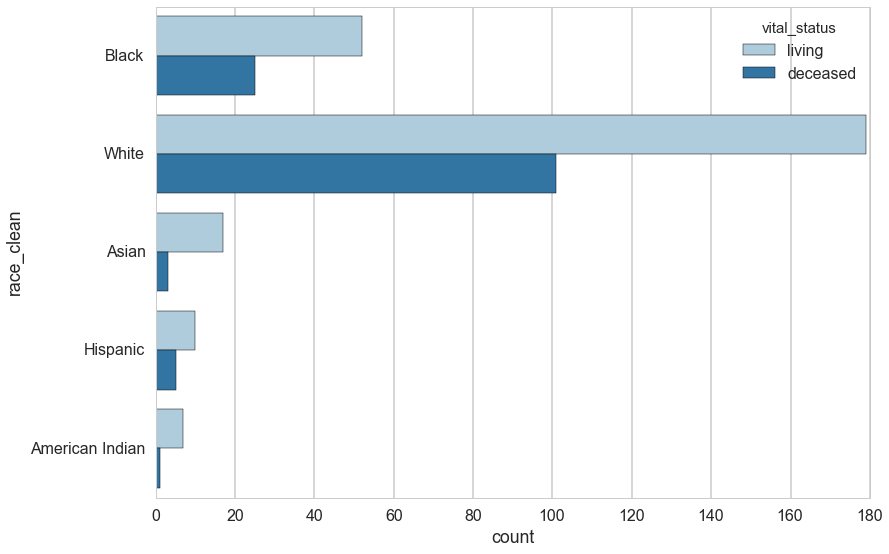

In [31]:
sns.set_palette("Paired")
sns.countplot(y="race_clean", hue = "vital_status", data=dem)

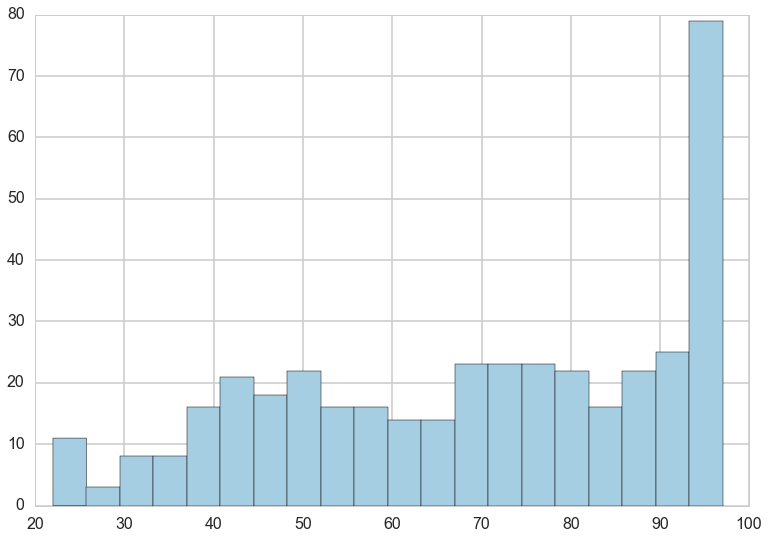

In [32]:
dem["age"].hist(bins=20)

In [33]:
dem_living = dem[dem["vital_status"] != "deceased"]

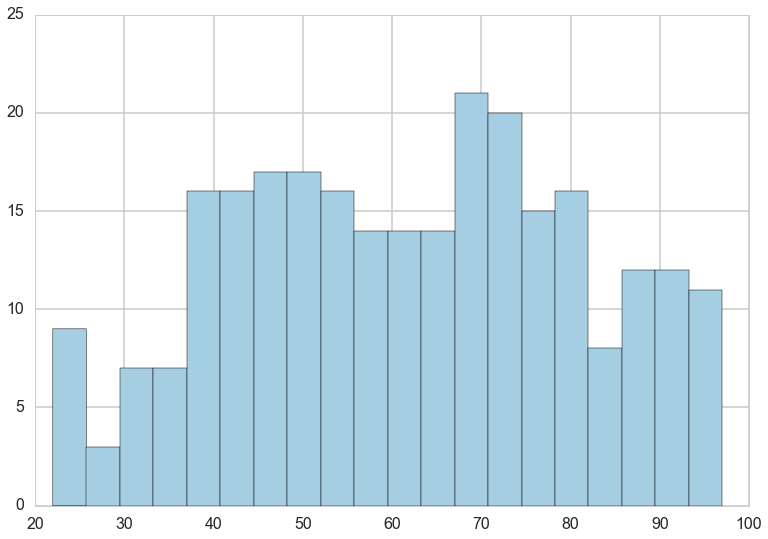

In [34]:
dem_living["age"].hist(bins=20)

In [35]:
bp = large[(large["bp_s"]!='')]
# bp.head()

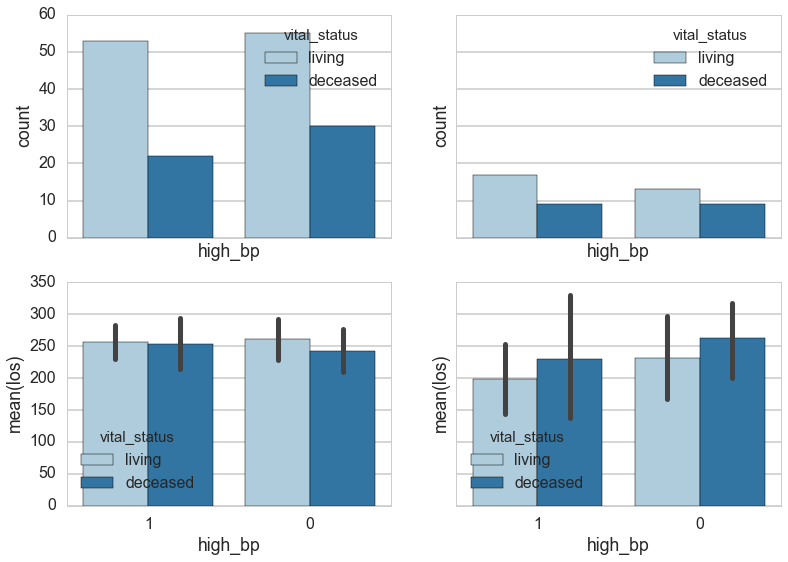

In [39]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

## patients seeing primary and outpatient physicians
sns.countplot(x="high_bp", hue="vital_status", data= bp[(large["dia_flag"] == "primary")\
                                                        &(large["inpatient_outpatient"] == "outpatient")], ax = ax1)
            
## patients seeing primary and inpatient physicians
sns.countplot(x="high_bp", hue="vital_status", data= bp[(large["dia_flag"] == "primary")\
                                                        &(large["inpatient_outpatient"] == "inpatient")], ax = ax2)

## patients seeing primary and outpatient physicians
sns.barplot(x="high_bp", y = "los", hue="vital_status", data= bp[(large["dia_flag"] == "primary")\
                                                                 &(large["inpatient_outpatient"] == "outpatient")], ax = ax3)
## patients seeing primary and inpatient physicians
sns.barplot(x="high_bp", y = "los", hue="vital_status", data= bp[(large["dia_flag"] == "primary")\
                                                                 &(large["inpatient_outpatient"] == "inpatient")], ax = ax4)


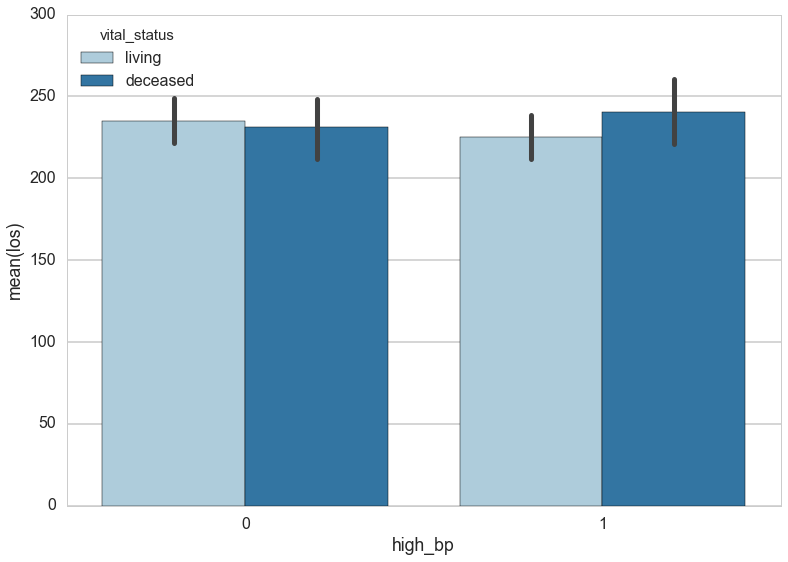

In [37]:
sns.barplot(x="high_bp", y = "los", hue="vital_status", data= bp)
# sns.barplot(x="gender", y = None, data= dem)